In [1]:
%pylab inline
%matplotlib inline

from IPython.display import display, Markdown, HTML
from matplotlib import animation, rc

from os.path import join
import sys
from subprocess import Popen, PIPE

from datetime import datetime, timedelta
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import cv2

import numpy as np
from scipy import misc

logging.info('Working with Python=%s, cv2=%s' % (sys.version, cv2.__version__))

Populating the interactive namespace from numpy and matplotlib


INFO:root:Working with Python=2.7.13 |Anaconda custom (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)], cv2=2.4.11


## Parameters

In [ ]:
THRESH = 40
OBSERVED_VALUE = 0
IMAGE_SHAPE = (512,512)

VID_SECS = 60
INTERVAL_MSECS = 10
PIXELS_PER_FRAME = 13

## Sources

In [2]:
PROJECT_ROOT = 'C:/Users/t-mibarg/Documents/Source/Repos/face-it/'
IMG_PATH = 'painter/examples/guy.jpg'
XML_PATH = 'painter/data/haarcascade_frontalface_alt.xml'
TMP_PATH = 'painter/examples/guy_tmp.jpg'
OUT_PATH = 'painter/frames/frame_'
IMAGE_PREPRO = 'painter/image_preprocessor.py'
PYTHON3 = 'C:/Anaconda3/Python.exe'

image_path = join(PROJECT_ROOT, IMG_PATH)
xml_path = join(PROJECT_ROOT, XML_PATH)
tmp_path = join(PROJECT_ROOT, TMP_PATH)
image_prepro = join(PROJECT_ROOT, IMAGE_PREPRO)
out_path = join(PROJECT_ROOT, OUT_PATH)

In [3]:
# Dependecies imports
sys.path.extend([PROJECT_ROOT,])
from painter.saliency.vid_painter import Painter
from painter.saliency.mrf import grid2mat, build_grid_graph
from painter.saliency.saliency_map import api as saliency_map

## Preprocess

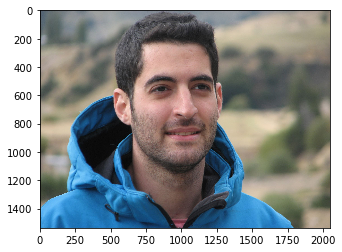

In [4]:
# read image
rgb_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB) # misc.imread(image_path)
gray_image = cv2.imread(image_path, cv2.COLOR_BGR2GRAY)[:,:,0]
plt.imshow(misc.imread(image_path))

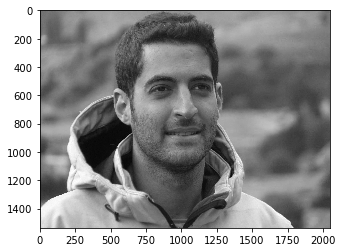

In [5]:
plt.imshow(gray_image, 'gray')

C:/Anaconda3/Python.exe C:/Users/t-mibarg/Documents/Source/Repos/face-it/painter/image_preprocessor.py --image='C:/Users/t-mibarg/Documents/Source/Repos/face-it/painter/examples/guy.jpg' --grey='C:/Users/t-mibarg/Documents/Source/Repos/face-it/painter/examples/guy_tmp.jpg' --xml='C:/Users/t-mibarg/Documents/Source/Repos/face-it/painter/data/haarcascade_frontalface_alt.xml'


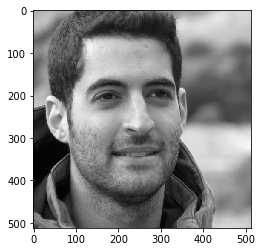

In [56]:
# apply Or's preprocessing
cmnd = "%s %s --image='%s' --grey='%s' --xml='%s'" % (PYTHON3, image_prepro, image_path, tmp_path, xml_path)
print(cmnd)
#process = Popen(cmnd, shell=True, stdout=PIPE)
#process.wait()

image_segment = cv2.imread(tmp_path) # misc.imread(image_path)
plt.imshow(misc.imread(tmp_path), 'gray')

#try:
#    os.remove(TMP_PATH)
#except OSError:
#    pass
#ip = ImagePreprocessor(image, xml=join(PROJECT_ROOT, XML_PATH))
#processed_image = ip.image_cropper()
#plt.imshow(processed_image, cmap='gray')

## Generate MRF

INFO:root:Started coor=(84L, 132L), number=0
INFO:root:Jumping to next salient location, no unobserved neighs, number=41


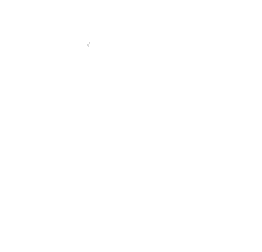

In [ ]:
painter = Painter(image_segment, dist_scale_thresh=THRESH, image_shape=IMAGE_SHAPE, observed_value=OBSERVED_VALUE)
frame_gen = painter.frame_gen()


fig = plt.figure()
plt.axis('off')


blank_img = np.multiply(np.ones(IMAGE_SHAPE), 255).astype(np.int)
blank_img[0] = 0
im = plt.imshow(blank_img, 'gray', animated=True)

def updatefig(*args):
    im.set_array(frame_gen.next())
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=painter.min_num_frames(), interval=INTERVAL_MSECS, blit=True)
rc('animation', html='html5')

In [ ]:
ani

INFO:root:Jumping to next salient location, no unobserved neighs, number=70
INFO:root:Moving to coor=(131L, 177L)
INFO:root:Started coor=(131L, 177L), number=1000
INFO:root:Jumping to next salient location, no unobserved neighs, number=1026
INFO:root:Jumping to next salient location, no unobserved neighs, number=1033
INFO:root:Jumping to next salient location, no unobserved neighs, number=1055
INFO:root:Jumping to next salient location, no unobserved neighs, number=1057
INFO:root:Jumping to next salient location, no unobserved neighs, number=1071
INFO:root:Moving to coor=(336L, 90L)
INFO:root:Started coor=(336L, 90L), number=2000
INFO:root:Jumping to next salient location, no unobserved neighs, number=2001
INFO:root:Moving to coor=(198L, 100L)
INFO:root:Started coor=(198L, 100L), number=3000
INFO:root:Jumping to next salient location, no unobserved neighs, number=3034
INFO:root:Jumping to next salient location, no unobserved neighs, number=3035
INFO:root:Jumping to next salient locatio

## Manual Vid Generation

In [ ]:
THRESH = 40
EXP_TRESH = np.exp(-THRESH)

# MRF works with grayscale
image_segment_2d = image_segment[:,:,0]

n, m = image_segment_2d.shape
g = build_grid_graph(n, m, image_segment_2d, np.zeros((n, m)))
g.init_in_msgs()

# compute saliency
maps = saliency_map(im=image_segment, is_markMaxima=False)
intensity = cv2.resize(maps.intensity, IMAGE_SHAPE)
plt.imshow(intensity, 'gray')
print('Non-blank pixel: %d' % np.count_nonzero(intensity))

def max_saliency(g, intensity):
    # mrf graph to value and observe matrices
    mat, obs = grid2mat(g, n, m, unobserved_to_belief=False)
    
    # obscured intensity by observed cells
    intensity[(obs==1)] = OBSERVED_VALUE
    
    # argmax coor
    argmax_coor = np.unravel_index(intensity.argmax(), intensity.shape)
    
    return g.get_vertex_by_coor(argmax_coor), intensity, obs

In [ ]:
cur_v, cur_intens, cur_obs = max_saliency(g, intensity)
next_v, cntr = None, 0
cur_image_segment = image_segment.copy()


while True:    
    if cntr % 1000 == 0:
        logging.info('Started coor=%s, number=%d' % (cur_v._coor, cntr))
    cntr += 1

    if cur_v._is_observed==False:
        # observe current
        cur_v._is_observed = True
    else:
        # cicle complete
        logging.info('Cicle complete. Passed through %d coors' % cntr)
        break

    # move by distribution
    next_v = g.move(cur_v, v_max=THRESH, exp_v_max=EXP_TRESH)
    if cntr % 1000 == 0:
        logging.info('Moving to coor=%s' % str(next_v._coor if next_v else ''))

    if next_v is None:
        if 0 <= cntr % 1000 <= 100:
            logging.info('Jumping to next salient location, no unobserved neighs, number=%d' % cntr)

        # no unobserved neighs
        next_v, cur_intens, cur_obs = max_saliency(g, cur_intens)
        
        # print current img
        cur_image_segment = image_segment_2d.copy()
        cur_image_segment[(cur_obs==0)] = 255
        cv2.imwrite(out_path + '%d.jpg' % cntr, cur_image_segment)

    cur_v = next_v

# graveyard

In [ ]:
# create console handler with a higher log level
ch = logging.StreamHandler()
#ch.setLevel(logging.INFO)
formatter = logging.Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S')
ch.setFormatter(formatter)

# add handler
logger.addHandler(ch)

In [ ]:
possible = [(100,100), (200,200), (300,300), (400,400), (500,500)]
i = 0

def get_start_point(g):
    global i
    c = possible[i]
    i = (i + 1) % len(possible)
    return g.get_vertex_by_coor(c)

#coor, _ = max_saliency(g)
#plt.imshow(intensity, 'gray')

In [ ]:
#gray_image = rgb2gray(image)
#plt.imshow(gray_image, cmap='gray')

# observed matrix
obs_mat = np.ones((1536, 2048))
obs_mat[500:900,500:900] = np.zeros((400, 400))

# obscured image
obs_image = gray_image.copy()
obs_image[500:900,500:900] = np.zeros((400, 400))
plt.imshow(obs_image, cmap='gray')

In [ ]:
THRESH = 40

# MRF works with grayscale
image_segment_2d = image_segment[:,:,0]

n, m = image_segment_2d.shape
g = build_grid_graph(n, m, image_segment_2d, np.zeros((n, m)))
g.init_in_msgs()

# compute saliency
maps = saliency_map(im=image_segment, is_markMaxima=False)
intensity = cv2.resize(maps.intensity, IMAGE_SHAPE)

def max_saliency(g, intensity):
    # mrf graph to value and observe matrices
    mat, obs = grid2mat(g, n, m, unobserved_to_belief=False)
    
    # obscured intensity by observed cells
    expanded_obs = np.concatenate((obs[...,np.newaxis], obs[...,np.newaxis], obs[...,np.newaxis]),axis=2)
    intensity[np.argwhere(expanded_obs==1)] = OBSERVED_VALUE
    
    # argmax coor
    argmax_coor = np.unravel_index(intensity.argmax(), intensity.shape)
    
    return g.get_vertex_by_coor(argmax_coor), intensity, obs

cur_v, cur_intens, cur_obs = max_saliency(g, intensity)
plt.imshow(cur_intens, 'gray')
next_v = None
frames = []
cntr = 0
cur_image_segment = image_segment.copy()

In [ ]:
logging.info('Started coor=%s, number=%d' % (cur_v._coor, cntr))
cntr += 1

if cur_v._is_observed==False:
    # observe current
    cur_v._is_observed = True
else:
    # cicle complete
    logging.info('Cicle complete. Passed through %d coors' % cntr)

# move by distribution
next_v = g.move(cur_v, v_max=THRESH)
logging.info('Moving to coor=%s' % str(next_v._coor if next_v else ''))

# save frame
frames.append(cur_obs)

if next_v is None:
    logging.info('Jumping to next salient location, no unobserved neighs, number=%d' % cntr)

    # no unobserved neighs
    next_v, cur_intens, cur_obs = max_saliency(g, cur_intens)
    #plt.imshow(cur_intens, 'gray')
    
    # print current img
    expanded_obs = np.concatenate((cur_obs[...,np.newaxis], cur_obs[...,np.newaxis], cur_obs[...,np.newaxis]),axis=2)
    cur_image_segment = image_segment.copy()
    cur_image_segment[(expanded_obs==0)] = 255
    plt.imshow(cur_image_segment, 'gray')

cur_v = next_v

In [ ]:
# run pairwise mrf
res = api(image, obs_mat, curve='line', iterations=2, verbose=True, msg_method='norm')
plt.imshow(res, cmap='gray')

In [ ]:
# MRF works with grayscale
cur_image_segment = image_segment.copy()
image_segment_2d = image_segment[:,:,0]

n, m = image_segment_2d.shape
g = build_grid_graph(n, m, image_segment_2d, np.zeros((n, m)))
g.init_in_msgs()

def max_saliency(g):
    # mrf graph to value and observe matrices
    mat, obs = grid2mat(g, n, m, unobserved_to_belief=False)
    
    # obscure observed cells in image
    ##expanded_obs = np.concatenate((obs[...,np.newaxis], obs[...,np.newaxis], obs[...,np.newaxis]),axis=2).shape
    ##cur_image_segment[np.argwhere(expanded_obs==False)] = OBSERVED_VALUE
    
    # compute saliency
    maps = saliency_map(im=cur_image_segment, is_markMaxima=False)
    intensity = cv2.resize(maps.intensity, IMAGE_SHAPE)
    
    # obscured intensity by observed cells
    expanded_obs = np.concatenate((obs[...,np.newaxis], obs[...,np.newaxis], obs[...,np.newaxis]),axis=2)
    intensity[np.argwhere(expanded_obs==False)] = OBSERVED_VALUE
    
    # argmax coor
    argmax_coor = np.unravel_index(intensity.argmin(), intensity.shape)
    
    return g.get_vertex_by_coor(argmax_coor), maps.intensity, obs

cur_v, _, cur_obs = max_saliency(g)
next_v = None
frames = []
cntr = 0


In [ ]:
image.shape

In [ ]:
# cut image to square
largest_powof2 = min(int(math.log(gray_image.shape[0], 2)), int(math.log(gray_image.shape[1], 2)))
margins = ((gray_image.shape[0] - pow(2, largest_powof2)) / 2, (gray_image.shape[1] - pow(2, largest_powof2)) / 2)
image_segment = gray_image[margins[0]:margins[0] + pow(2, largest_powof2), margins[1]:margins[1] + pow(2, largest_powof2)]
observed_segment = obs_mat[margins[0]:margins[0] + pow(2, largest_powof2), margins[1]:margins[1] + pow(2, largest_powof2)]
n, m = image_segment.shape

plt.imshow(image_segment, cmap='gray')

In [ ]:
# obscured image segment
obs_image_segment = np.multiply(image_segment, observed_segment)
plt.imshow(obs_image_segment, cmap='gray')